In [79]:
import spacy

nlp = spacy.load("fr_core_news_lg")

In [80]:
from pathlib import Path

import pandas as pd

DATA_FOLDER = Path(".") / "data"
PARTIES = list(DATA_FOLDER.glob("*.csv"))

dataset = pd.concat([pd.read_csv(party) for party in parties]).reset_index()

In [81]:
import numpy as np

embeddings = np.array([t.vector for t in nlp.pipe(dataset["tweet"])])
embeddings

In [ ]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2, init='random').fit_transform(embeddings)

docs_2d = pd.DataFrame(t_sne, columns=["x", "y"])
docs_2d["category"] = dataset["account"].astype("category")
docs_2d

,x,y,category
0,25.234447,-33.974911,FranceInsoumise
1,40.129929,-14.238421,FranceInsoumise
2,21.900873,15.109356,FranceInsoumise
3,-9.811928,-1.952378,FranceInsoumise
4,13.330691,-18.211075,FranceInsoumise
...,...,...,...
1665,-3.122763,-13.124894,partisocialiste
1666,0.385886,-15.894263,partisocialiste
1667,-2.802234,-15.351489,partisocialiste
1668,-2.157199,-15.717866,partisocialiste


<AxesSubplot: xlabel='x', ylabel='y'>

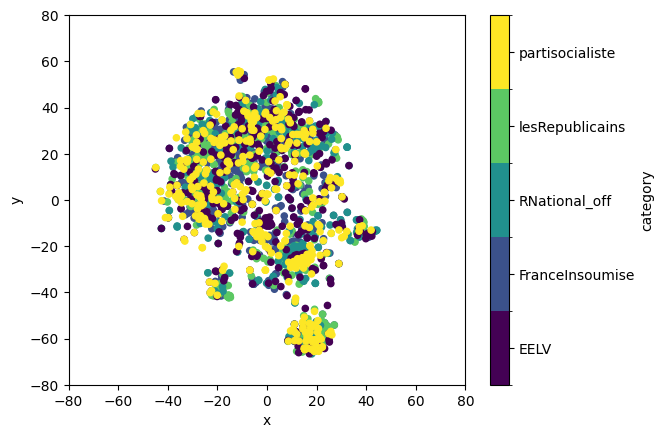

In [ ]:
docs_2d.plot.scatter(x="x", y="y", c="category", colormap="viridis")

<AxesSubplot: xlabel='x', ylabel='y'>

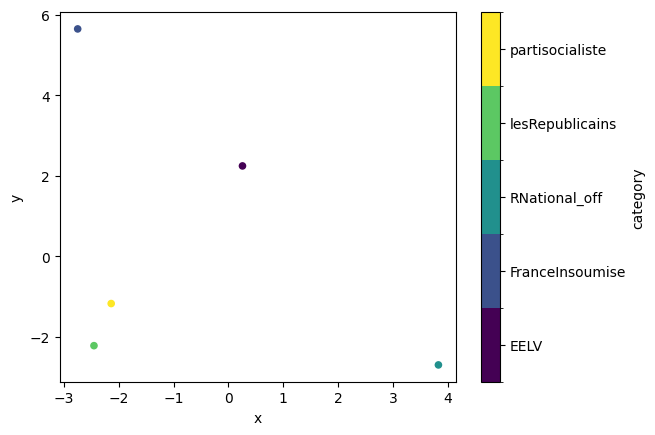

In [ ]:
centroids = docs_2d.groupby('category').mean()
centroids["category"] = centroids.index
centroids.plot.scatter(x="x", y="y", c="category", colormap="viridis")